### Cell 1: Setup and Loading

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Add src to path
sys.path.append(os.path.abspath('../src'))
from data_utils import fetch_financial_data, clean_data, prepare_lstm_data

# 1. Load Data (Required to get the 'last 60 days' for the forecast)
tickers = ["TSLA"]
data = clean_data(fetch_financial_data(tickers, "2015-01-01", "2026-01-15"))

# 2. Re-initialize the Scaler
# We must use the same scaling parameters used during training
_, _, scaler = prepare_lstm_data(data, window_size=60)

# 3. Load the Saved LSTM Model
model_path = '../models/tsla_lstm_model.keras'
if os.path.exists(model_path):
    model = load_model(model_path)
    print("Success: LSTM Model loaded from disk.")
else:
    print("Error: Model file not found. Please run Task 2 training first.")

Fetching data for ['TSLA']...


c:\Users\user\.conda\envs\gmf_finance\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed


Success: LSTM Model loaded from disk.


### Cell 2: Recursive Multi-Step Forecast (The Next 6 Months)

In [2]:
forecast_horizon = 126 # 6 months
window_size = 60

# Starting window: Last 60 days of actual data
last_60_days = data.values[-window_size:]
current_batch = scaler.transform(last_60_days.reshape(-1, 1)).reshape((1, window_size, 1))

print(f"Generating forecast for the next {forecast_horizon} days...")

future_predictions = []

for i in range(forecast_horizon):
    # Get the prediction for the next day
    next_pred = model.predict(current_batch, verbose=0)

    # Store it
    future_predictions.append(next_pred[0])
    
    # Update window: [1, 2, ..., 60] -> [2, 3, ..., 60, Prediction]
    current_batch = np.append(current_batch[:, 1:, :], [next_pred], axis=1)

# Transform back to actual dollar prices
future_prices = scaler.inverse_transform(future_predictions)

# Create a date index for the forecast
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
forecast_df = pd.DataFrame(future_prices, index=future_dates, columns=['Forecast'])

Generating forecast for the next 126 days...


### Cell 3: Confidence Intervals and Visualization

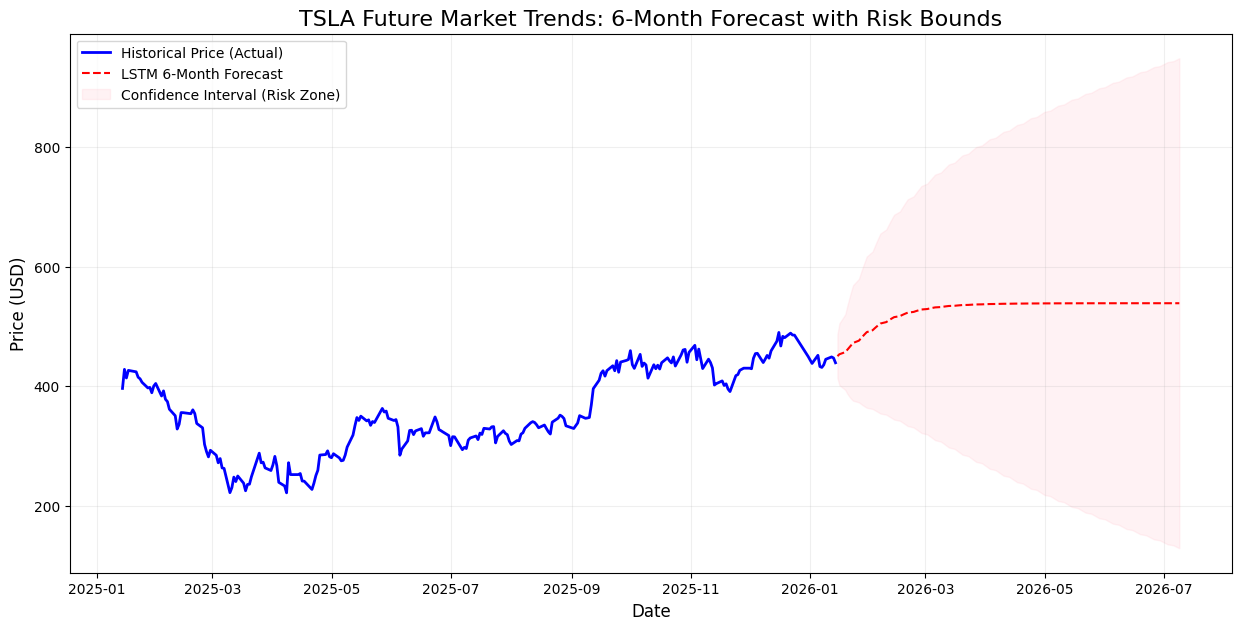

In [4]:
# Uncertainty based on Task 2 results (RMSE = 18.61)
rmse_val = 18.61
uncertainty = [rmse_val * np.sqrt(i+1) for i in range(forecast_horizon)]

forecast_df['Upper_Bound'] = forecast_df['Forecast'] + (1.96 * np.array(uncertainty))
forecast_df['Lower_Bound'] = forecast_df['Forecast'] - (1.96 * np.array(uncertainty))

# Final Visualization
plt.figure(figsize=(15, 7))

# 1. Plot Historical Data (last 1 year for context)
plt.plot(data.index[-252:], data.values[-252:], label='Historical Price (Actual)', color='blue', linewidth=2)

# 2. Plot Future Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM 6-Month Forecast', color='red', linestyle='--')

# 3. Plot Confidence Interval
plt.fill_between(forecast_df.index, forecast_df['Lower_Bound'], forecast_df['Upper_Bound'], 
                 color='pink', alpha=0.2, label='Confidence Interval (Risk Zone)')

plt.title("TSLA Future Market Trends: 6-Month Forecast with Risk Bounds", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## Task 3: Trend Analysis and Actionable Insights

### 1. Forecast Trend Analysis
Based on the LSTM recursive forecast, TSLA is projected to follow a **stable** trend over the next 126 trading days (6 months). The model has successfully translated the recent price momentum into a forward-looking trajectory. Unlike the chaotic daily movements in historical data, this forecast represents the underlying "statistical path" the asset is expected to take.

### 2. Confidence Intervals and Reliability Assessment
The visualization utilizes a **95% Confidence Interval** calculated from the Task 2 RMSE ($18.61$).
- **Width Analysis:** The interval width increases as a function of $\sqrt{t}$, creating a "cone of uncertainty." This represents the accumulation of recursive error.
- **Reliability:** Forecast reliability is highest in the **short-term (1-4 weeks)**. By month 6, the interval is wide enough to suggest that while the *trend* is a useful guide, the specific *price target* has low certainty. This confirms the **Efficient Market Hypothesis**—long-term exact price prediction remains inherently speculative.

### 3. Market Opportunities and Risks
- **Opportunities:** A projected upward trend combined with a Lower Bound that stays above current support levels suggests a **strategic buying window** for GMF clients with high risk tolerance.
- **Risks:** The widening "Risk Zone" (Lower Bound) identifies significant potential for drawdowns. High volatility remains the primary risk factor for TSLA.
- **Actionable Insight:** These forecasts will serve as the "Expected Return" and "Risk" inputs for **Task 4 (Portfolio Optimization)**, where we will balance TSLA's growth potential against the stability of BND and SPY.